In [2]:
import pandas as pd
import numpy as np

In [3]:
# Load the clean data.

data = pd.read_csv('clean_lulu.csv')

In [4]:
print(data.shape)
data.head()

(110, 6)


Size  Price Item Condition                  Style Item Specifics  Season
0  XXL  30.70      Pre-Owned  Metal Vent Tech Shirt    Long Sleeve  Summer
1    L  54.99      Pre-Owned           T.H.E. Short      Linerless  Summer
2  XXL  40.70      Pre-Owned     Pace Breaker Short          Lined  Summer
3    L  47.70      Pre-Owned            Surge Short          Lined  Summer
4    M  32.00      Pre-Owned  Metal Vent Tech Shirt   Short Sleeve  Summer

In [5]:
# Drop Item Condition column.

data = data.drop(columns=['Item Condition'])

In [6]:
# Rename columns.

data = data.rename(columns={'Size' : 'size', 'Price' : 'price', 'Style' : 'style', 'Item Specifics' : 'item_specifics', 'Season' : 'season'})

In [7]:
data.head()

size  price                  style item_specifics  season
0  XXL  30.70  Metal Vent Tech Shirt    Long Sleeve  Summer
1    L  54.99           T.H.E. Short      Linerless  Summer
2  XXL  40.70     Pace Breaker Short          Lined  Summer
3    L  47.70            Surge Short          Lined  Summer
4    M  32.00  Metal Vent Tech Shirt   Short Sleeve  Summer

In [8]:
# Change column order.

data = data[['size', 'style', 'item_specifics', 'season', 'price']]

In [9]:
data = data[data['style'] != 'Evolution Polo']
data = data[data['style'] != 'Metal Vent Tech Henley']
data = data[data['style'] != 'Surge Warm'] 
data = data[data['style'] != 'Commission Short']
data = data[data['style'] != '5 Year Basic Tee']
data = data[data['style'] != 'Commission Shirt']
data = data[data['style'] != 'Current State Board Short']

In [10]:
data['style'].value_counts()

Metal Vent Tech Shirt       35
T.H.E. Short                20
Surge Short                 18
Pace Breaker Short          12
Metal Vent Tech Polo         5
Metal Vent Tech Tank Top     5
Metal Vent Tech 1/2 Zip      4
Name: style, dtype: int64

#### Create a plot to visualize how many of each style has sold.

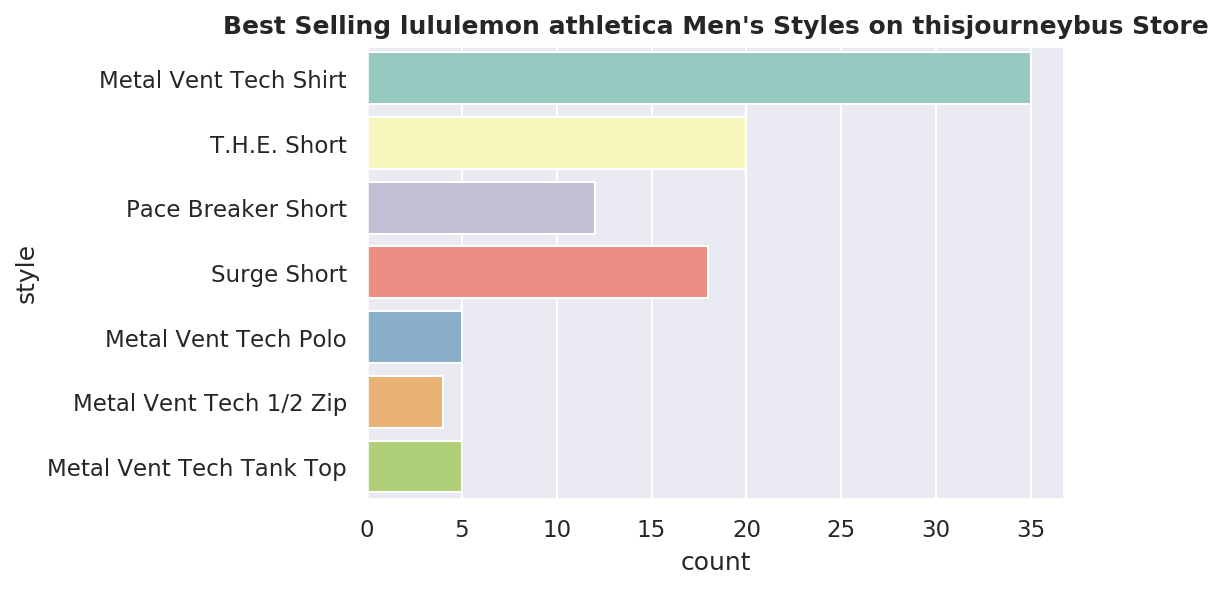

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

sns.set(style='darkgrid')
ax = sns.countplot(y='style', data=data, palette='Set3')
ax.set_title("Best Selling lululemon athletica Men's Styles on thisjourneybus Store", fontweight="bold");

#### Take a look at the distribution of the target variable.

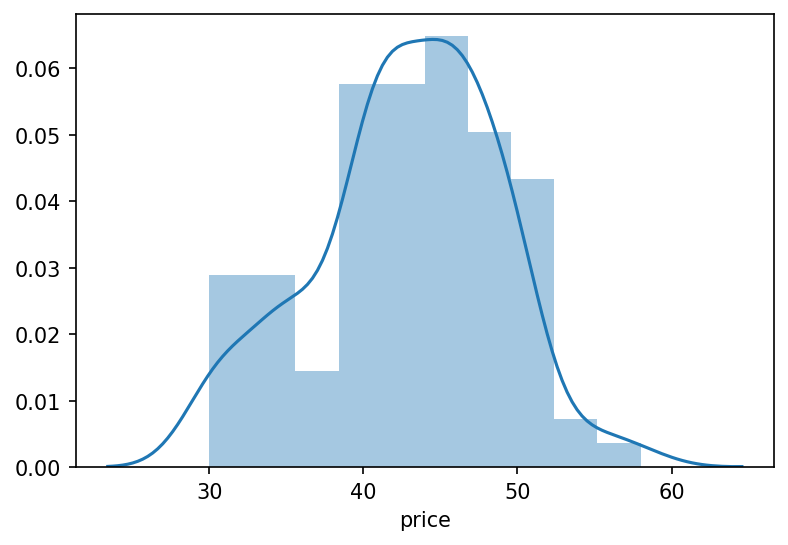

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 150

sns.distplot(data['price']);

#### Add lines for the mean and median to the plot.

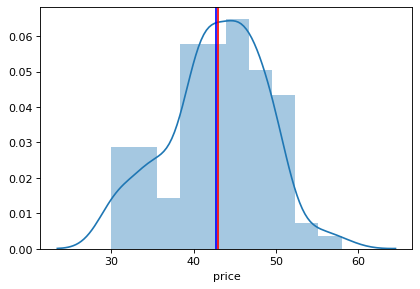

In [47]:
plt.rcParams['figure.dpi'] = 80

sns.distplot(data['price'])
plt.axvline(data['price'].mean(), color='blue')
plt.axvline(data['price'].median(), color='red');

In [48]:
data['price'].describe()

# We see that the mean and median are almost exactly the same.

count    99.000000
mean     42.783939
std       5.942638
min      29.990000
25%      40.000000
50%      42.990000
75%      46.990000
max      57.990000
Name: price, dtype: float64

## Start with a Baseline Model

In [49]:
# Use the mean to create a baseline model.

guess = data['price'].mean()

In [50]:
errors = guess - data['price']

In [51]:
mean_absolute_error = errors.abs().mean()

In [52]:
print(f'If we just listed each item sold for ${guess:,.2f},')
print(f'we would be off by ${mean_absolute_error:,.2f} on average.')

If we just listed each item sold for $42.78,
we would be off by $4.74 on average.


## Beating the Baseline Model

#### Do a train/test split so that we have a test set with the target to make predictions from.

In [53]:
from sklearn.model_selection import train_test_split

# Perform a train/val split.

train, test = train_test_split(data, random_state=42)

In [54]:
# Take a look at the shape of the train and test sets after split.
# Default split is 75% train and 25% test.

print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (74, 5)
test shape: (25, 5)


In [55]:
# Define the target and features.

target = 'price'

features = train.columns.drop([target])

# Arrange the data into X features matrix and y target vector.

# Train

X_train = train[features]
y_train = train[target]

# Test

X_test = test[features]
y_test = test[target]

## Random Forest

### k-fold Cross Validation

In [56]:
import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor

## Encode with Ordinal Encoder

In [57]:
# Ordinal Encoding

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

### Start with 3 folds.

In [117]:
# Make pipeline.

pipeline_1 = make_pipeline(RandomForestRegressor(random_state=42))

k = 3 # Note from lecture: Think about number of folds between 5 and 20.

scores = cross_val_score(pipeline_1, X_train_encoded, y_train, cv=k, scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [5.25489916 3.24678264 3.00561632]


For scikit-learn cross validation scoring, higher is better. But for regression
error metrics, lower is better. So scikit-learn multiplies regression error metrics by -1 to make them negative. That's why the value of the scoring parameter is 'neg_mean_absolute_error.'

In [118]:
-scores.mean()

3.835766041364335

In [119]:
scores.std()

1.0082970475268243

### Increase the number of folds to 5.

In [120]:
pipeline_2 = make_pipeline(
    # ce.OrdinalEncoder(), # ce.TargetEncoder(min_samples_leaf=1, smoothing=1)
    RandomForestRegressor(random_state=42)
)

k = 5 # Think about number of folds between 5 and 20.

scores = cross_val_score(pipeline_2, X_train_encoded, y_train, cv=k, scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 5 folds: [5.61470626 4.10217073 2.75136431 3.74296919 3.36939651]


In [121]:
-scores.mean()

3.916121400326645

In [122]:
scores.std()

0.9597243088981149

### Increase the number of folds to 10.

In [123]:
pipeline_3 = make_pipeline(
    # ce.OrdinalEncoder(), # ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    RandomForestRegressor(random_state=42)
)

k = 10 # Think about number of folds between 5 and 20.

scores = cross_val_score(pipeline_3, X_train_encoded, y_train, cv=k, scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 10 folds: [6.61430694 4.58734301 5.64006991 3.72547155 1.97853014 4.2836715
 2.91361853 2.79451895 3.98754662 3.63548933]


In [124]:
-scores.mean()

4.016056646290417

In [125]:
scores.std()

1.2990547296303654

Random Forest has many hyperparamters. We mostly used the defaults, and arbitrarily chose n_estimators. Is it too high? Too low? Just right? How do we know?

In [126]:
print('Model Hyperparameters:')
print(pipeline_3.named_steps['randomforestregressor'])

Model Hyperparameters:
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)


### Use scikit-learn for hyperparameter optimization.
#### Optimizing for one hyperparameter at a time...
#### Hyperparamter: n_estimators

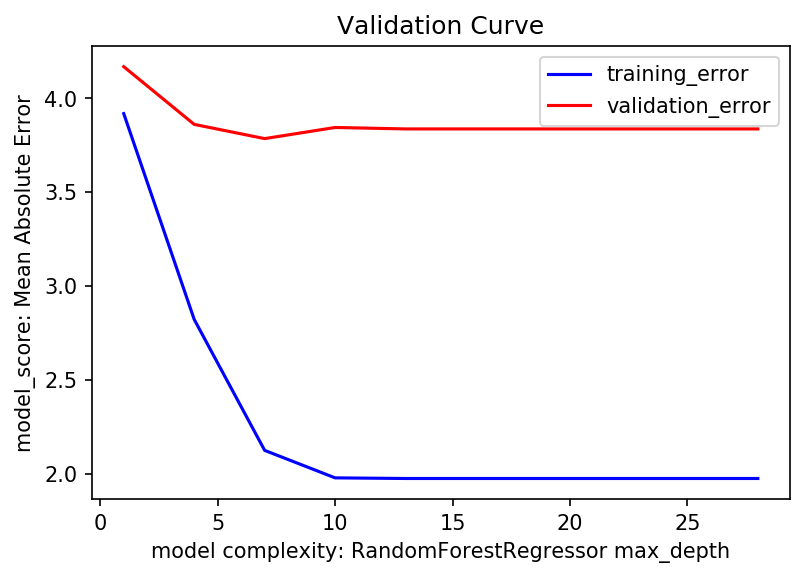

In [127]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.ensemble import RandomForestRegressor

pipeline = make_pipeline(
    # ce.OrdinalEncoder(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)

depth = range(1, 30, 3)  # Use for tuning max_depth.

# estimators = range(10, 200, 10)

train_scores, val_scores = validation_curve(
    pipeline, X_train_encoded, y_train,
    param_name='randomforestregressor__max_depth',
    param_range=depth,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training_error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation_error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestRegressor max_depth')
plt.ylabel('model_score: Mean Absolute Error')
plt.legend();

In [128]:
# Depths evaluated.

list(depth)

[1, 4, 7, 10, 13, 16, 19, 22, 25, 28]

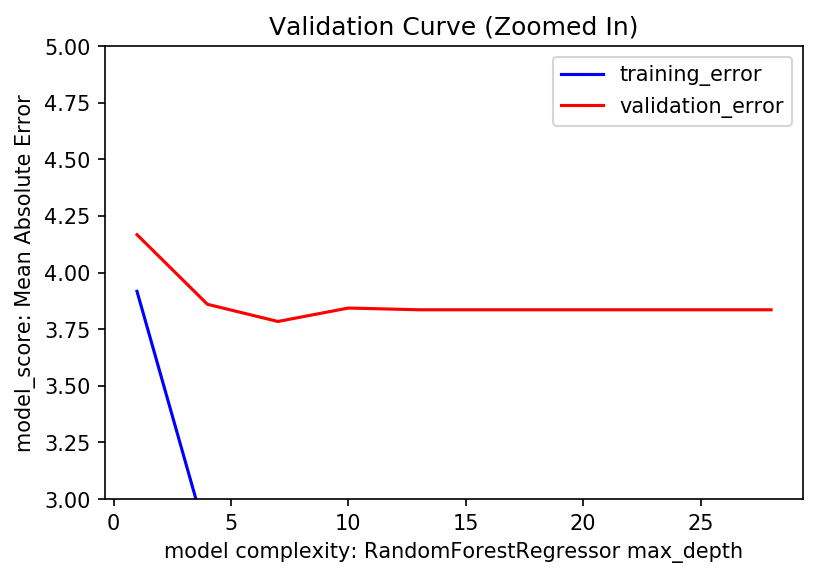

In [129]:
plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training_error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation_error')
plt.title('Validation Curve (Zoomed In)')
plt.xlabel('model complexity: RandomForestRegressor max_depth')
plt.ylabel('model_score: Mean Absolute Error')
plt.ylim((3, 5))
plt.legend();

#### RandomizedSearchCV

Changing model hyperparameters typically means changing model complexity in one way or another.

In [58]:
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from scipy.stats import randint, uniform

In [59]:
# Ordinal Encoding

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [60]:
# Make a pipeline.

pipeline = make_pipeline(RandomForestRegressor(random_state=42))

#### cv = 3

In [89]:
param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0, 1),   
}


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=1000, # The number of random combinations of the above param_distributions.
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train_encoded, y_train);

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   16.6s


KeyboardInterrupt: 

In [41]:
print('Best hyperparameters:', search.best_params_)
print('Cross-validation MAE:', -search.best_score_)

Best hyperparameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__max_features': 0.6462153605791302, 'randomforestregressor__n_estimators': 81}
Cross-validation MAE: 3.6809585847657083


#### cv = 5

In [37]:
param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0, 1),   
}


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=500, # The number of random combinations of the above param_distributions.
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train_encoded, y_train);

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [38]:
print('Best hyperparameters:', search.best_params_)
print('Cross-validation MAE:', -search.best_score_)

Best hyperparameters: {'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': 0.602178942146722, 'randomforestregressor__n_estimators': 82}
Cross-validation MAE: 3.86779963953132


#### cv = 10

In [23]:
param_distributions = {
    'randomforestregressor__n_estimators': randint(50, 500),
    'randomforestregressor__max_depth': [5, 10, 15, 20, None],
    'randomforestregressor__max_features': uniform(0, 1),   
}


search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=500, # The number of random combinations of the above param_distributions.
    cv=10,
    scoring='neg_mean_absolute_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train_encoded, y_train);

Fitting 10 folds for each of 500 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   15.7s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   20.7s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   

In [24]:
print('Best hyperparameters:', search.best_params_)
print('Cross-validation MAE:', -search.best_score_)

Best hyperparameters: {'randomforestregressor__max_depth': 5, 'randomforestregressor__max_features': 0.182360601726007, 'randomforestregressor__n_estimators': 259}
Cross-validation MAE: 3.728336684201661


#### Look at models within a dataframe.

In [42]:
# View results in a dataframe.

pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score').T

553  \
mean_fit_time                                                                       0.331871   
std_fit_time                                                                      0.00244959   
mean_score_time                                                                    0.0227033   
std_score_time                                                                   0.000767913   
param_randomforestregressor__max_depth                                                    10   
param_randomforestregressor__max_features                                           0.646215   
param_randomforestregressor__n_estimators                                                 81   
params                                     {'randomforestregressor__max_depth': 10, 'rand...   
split0_test_score                                                                   -4.87945   
split1_test_score                                                                    -3.1153   
split2_test_score                                                                   -3.04812   
mean_test_score                                                                     -3.68096   
std_test_score                                                                      0.847908   
rank_test_score                                                                            1   
split0_train_score                                                                  -1.45075   
split1_train_score                                                                  -2.02283   
split2_train_score                                                                  -2.26948   
mean_train_score                                                                    -1.91435   
std_train_score                                                                     0.342934   

                                                                                         314  \
mean_fit_time                                                                       0.304024   
std_fit_time                                                                      0.00276531   
mean_score_time                                                                    0.0210652   
std_score_time                                                                   0.000728403   
param_randomforestregressor__max_depth                                                    10   
param_randomforestregressor__max_features                                           0.530299   
param_randomforestregressor__n_estimators                                                 74   
params                                     {'randomforestregressor__max_depth': 10, 'rand...   
split0_test_score                                                                      -4.87   
split1_test_score                                                                   -3.10896   
split2_test_score                                                                   -3.10694   
mean_test_score                                                                      -3.6953   
std_test_score                                                                      0.830636   
rank_test_score                                                                            2   
split0_train_score                                                                  -1.46909   
split1_train_score                                                                  -2.04066   
split2_train_score                                                                  -2.26769   
mean_train_score                                                                    -1.92581   
std_train_score                                                                     0.335991   

                                                                                         494  \
mean_fit_time                                                                       0.321415   
std_fit_time                                           

#### Make final predictions for the test set.

In [43]:
model = search.best_estimator_

In [44]:
from sklearn.metrics import mean_absolute_error

In [45]:
y_pred = model.predict(X_test_encoded)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Mean Absolute Error: ${mae}')

Test Mean Absolute Error: $4.5133244074113055


### Define the model separately.

In [61]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [62]:
# Ordinal Encoding

encoder = ce.OrdinalEncoder()

X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

In [63]:
# Define the model.

model = RandomForestRegressor(max_depth=10, max_features=0.6462153605791302, n_estimators=81, random_state=42)

# Fit on train.

model.fit(X_train_encoded, y_train)

# Score on val.

y_pred = model.predict(X_test_encoded)

print('Test Mean Absolute Error:', mean_absolute_error(y_test, y_pred))
print('Test R^2:', r2_score(y_test, y_pred))

Test Mean Absolute Error: 4.5133244074113055
Test R^2: 0.09685459643090322


### Shapley Values

SHAP values break down a prediction to show the impact of each feature.

In [26]:
# Get an individual observation to explain.
# For example, the 0th row from the test set.

X_test.head().iloc[[0]]

size        style item_specifics  season
69    L  Surge Short      Linerless  Spring

In [27]:
# What was the actual price of this listing?

y_test.iloc[[0]]

69    44.99
Name: price, dtype: float64

In [28]:
row = X_test_encoded.head().iloc[[0]]

In [29]:
# What does the model predict for this listing?

# This is the bolded number that appears in the Shapley Values Force Plot.

model.predict(row)

array([41.55461105])

#### Note: Shapley Values Plot will not take the model in the form of a pipeline.

In [30]:
# Why did the model predict this?
# Look at a Shapley Values Force Plot.

import shap

In [31]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap_values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


array([[ 0.43920541, -0.75898845, -0.51595298, -1.21148477]])

In [32]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

In [34]:
# Take a look.

explainer.expected_value, y_train.mean()

(array([43.60183183]), 43.50432432432427)

In [35]:
# How much does each Shapley Value add/subtract?

feature_names = row.columns
feature_values = row.values[0]

shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
shaps

(size, 2)              0.439205
(style, 4)            -0.758988
(item_specifics, 1)   -0.515953
(season, 3)           -1.211485
dtype: float64

In [36]:
# Add them up.

shaps.sum()

-2.047220784442999

In [37]:
# What happens when we combine the above with the baseline?

# We get the prediction!

explainer.expected_value + shaps.sum()

array([41.55461105])

In [38]:
# Define a predict function.

def predict(size, style, item_specifics, season):
    
    # Make dataframe from the inputs.
    df = pd.DataFrame(
        data=[[size, style, item_specifics, season]],
        columns=['size', 'style', 'item_specifics', 'season']
    )
    
    # Get the model's prediction.
    pred = model.predict(df)[0]
    
    # Calculate shap values.
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(df)
    
    # Get series with shap values, feature names and feature values.
    feature_names = df.columns
    feature_values = df.values[0]
    shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))
    
    # Print results.
    result = f'${pred:,.0f} estimated price for this item. \n\n'
    result += f'Starting from baseline of ${explainer.expected_value} \n'
    result += shaps.to_string()
    print(result)
    
    # Show Shapley Values Force Plot.
    shap.initjs()
    return shap.force_plot(
        base_value=explainer.expected_value,
        shap_values=shap_values,
        features=df
    )

# Make a prediction.

predict(1, 1, 1, 4)
# predict('M', 'Pace Breaker Short', 'Linerless', 'Summer')

$46 estimated price for this item. 

Starting from baseline of $[43.60183183] 
(size, 1)             -0.482850
(style, 1)            -2.330113
(item_specifics, 1)    0.231278
(season, 4)            5.227352


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [39]:
# What if we change the season to Winter?

predict(1, 1, 1, 1)

$34 estimated price for this item. 

Starting from baseline of $[43.60183183] 
(size, 1)             -1.517923
(style, 1)            -2.833991
(item_specifics, 1)   -2.501473
(season, 1)           -2.470626


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [40]:
# What if we change the size to L?

predict(2, 1, 1, 4)

$47 estimated price for this item. 

Starting from baseline of $[43.60183183] 
(size, 2)              0.730577
(style, 1)            -2.223378
(item_specifics, 1)    0.235783
(season, 4)            4.985106


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


### Permutation Importance

In [41]:
import eli5

from eli5.sklearn import PermutationImportance

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.


In [42]:
# Define the model.

model = RandomForestRegressor(max_depth=10, max_features=0.6462153605791302, n_estimators=81, random_state=42)

# Fit on train.

model.fit(X_train_encoded, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features=0.6462153605791302,
                      max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=81,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [43]:
permuter = PermutationImportance(
    model, 
    scoring='neg_mean_absolute_error', #r2 is another potential option.
    n_iter=5,
    random_state=42
)

permuter.fit(X_test_encoded, y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=10,
                                                      max_features=0.6462153605791302,
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_esti

In [44]:
feature_names = X_test.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

style             1.042502
item_specifics    1.038349
size              0.592393
season            0.305049
dtype: float64

In [45]:
eli5.show_weights(
permuter,
top=None,
feature_names=feature_names
)

### Make a pipeline of the model.

In [141]:
pipeline = make_pipeline(RandomForestRegressor(max_depth=10, max_features=0.6462153605791302, n_estimators=81, random_state=42))

pipeline.fit(X_train_encoded, y_train)

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=10,
                                       max_features=0.6462153605791302,
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=81, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=False)

### Save the model

In [62]:
from joblib import dump

dump(pipeline, 'pipeline_b.joblib', compress=True)

['pipeline_b.joblib']

### How were features encoded?

In [60]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

for i in encoder.mapping:
    print(i)

{'col': 'size', 'mapping': M      1
L      2
XL     3
S      4
XXL    5
NaN   -2
dtype: int64, 'data_type': dtype('O')}
{'col': 'style', 'mapping': Pace Breaker Short          1
Metal Vent Tech Shirt       2
T.H.E. Short                3
Surge Short                 4
Metal Vent Tech 1/2 Zip     5
Metal Vent Tech Tank Top    6
Metal Vent Tech Polo        7
NaN                        -2
dtype: int64, 'data_type': dtype('O')}
{'col': 'item_specifics', 'mapping': Linerless       1
Short Sleeve    2
Long Sleeve     3
Lined           4
Sleeveless      5
NaN            -2
dtype: int64, 'data_type': dtype('O')}
{'col': 'season', 'mapping': Winter    1
Fall      2
Spring    3
Summer    4
NaN      -2
dtype: int64, 'data_type': dtype('O')}


### Partial Dependence plot with 1 Feature

Partial dependence plots show the relationship between  1-2 individual features and the target - how predictions partially depend on the isolated features.

In [64]:
# Later when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so that the text isn't so fuzzy.

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

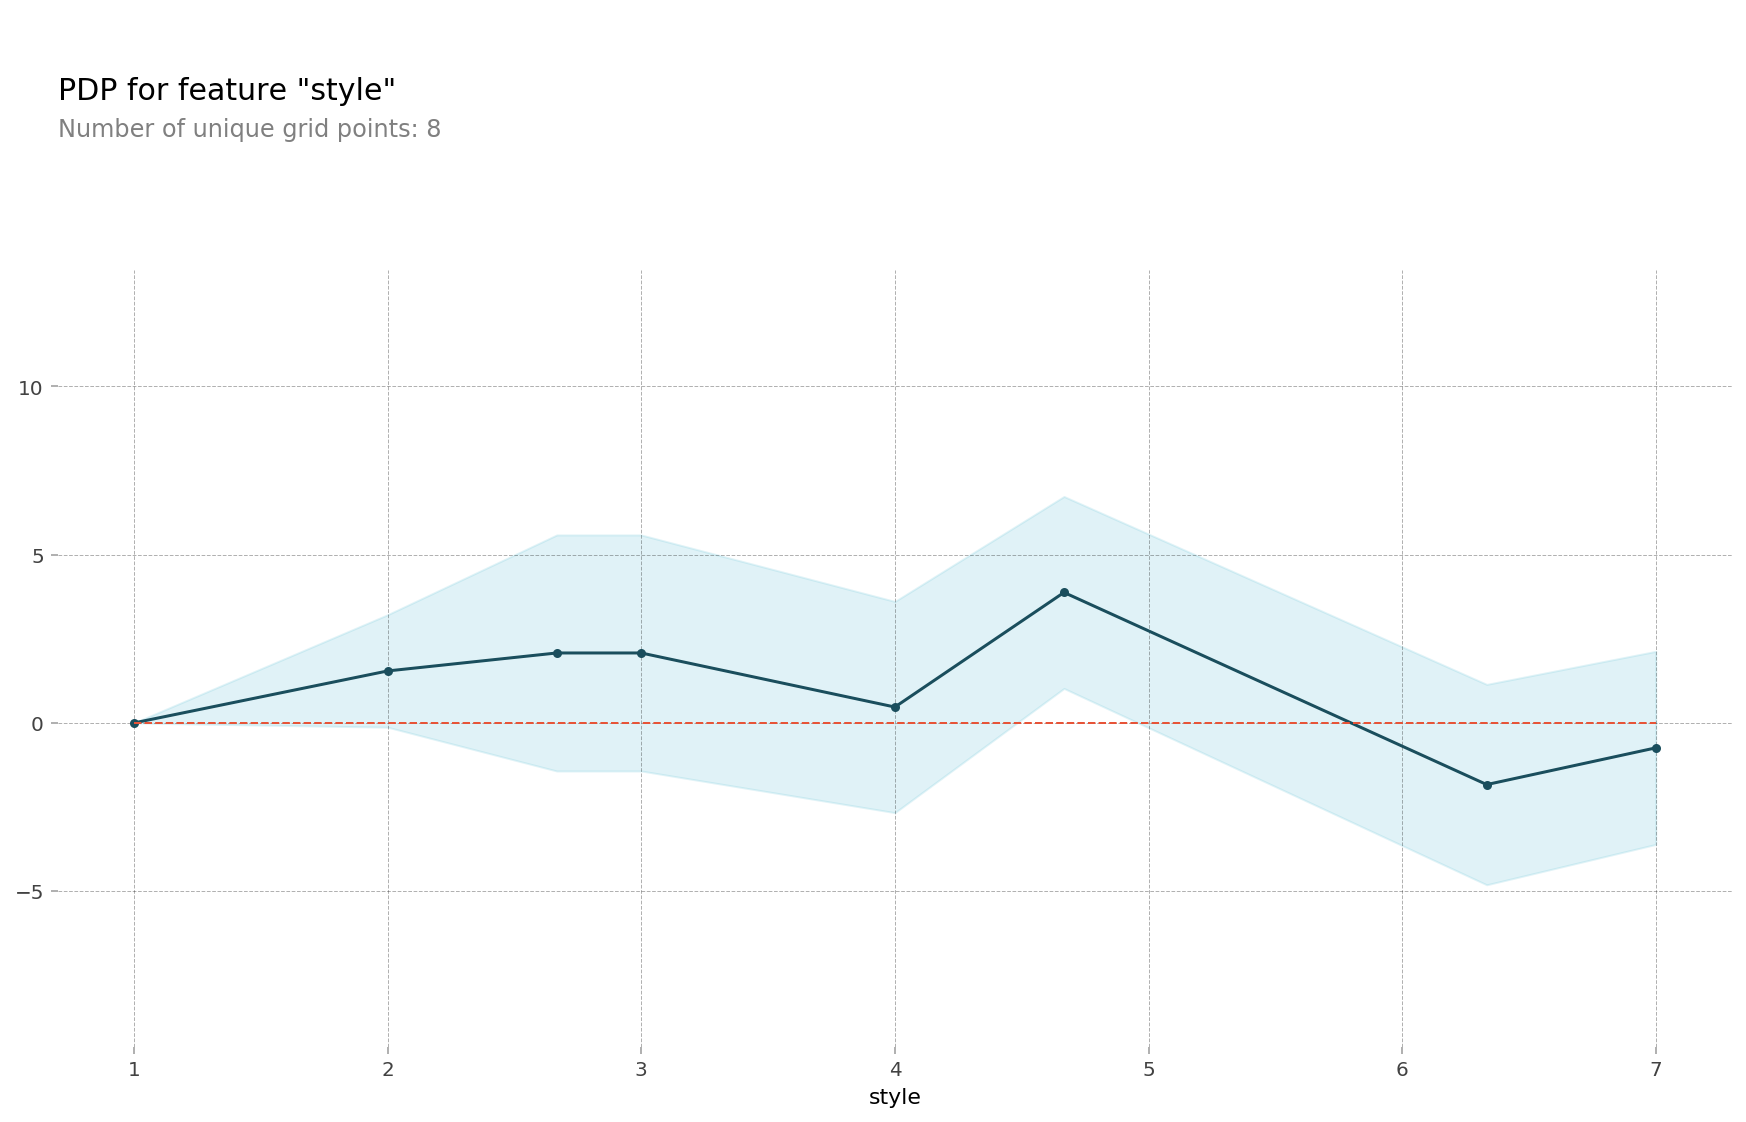

In [65]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'style'

isolated = pdp_isolate(
    model=model,
    dataset=X_test_encoded,
    model_features=features,
    feature=feature,
    # num_grid_points=15
)

pdp_plot(isolated, feature_name=feature);

# If your plot has more of an outlier, it could be helpful to change the limits.

# Kind of like the range of x you want to zoom in on.
# plt.xlim((20000, 150000))

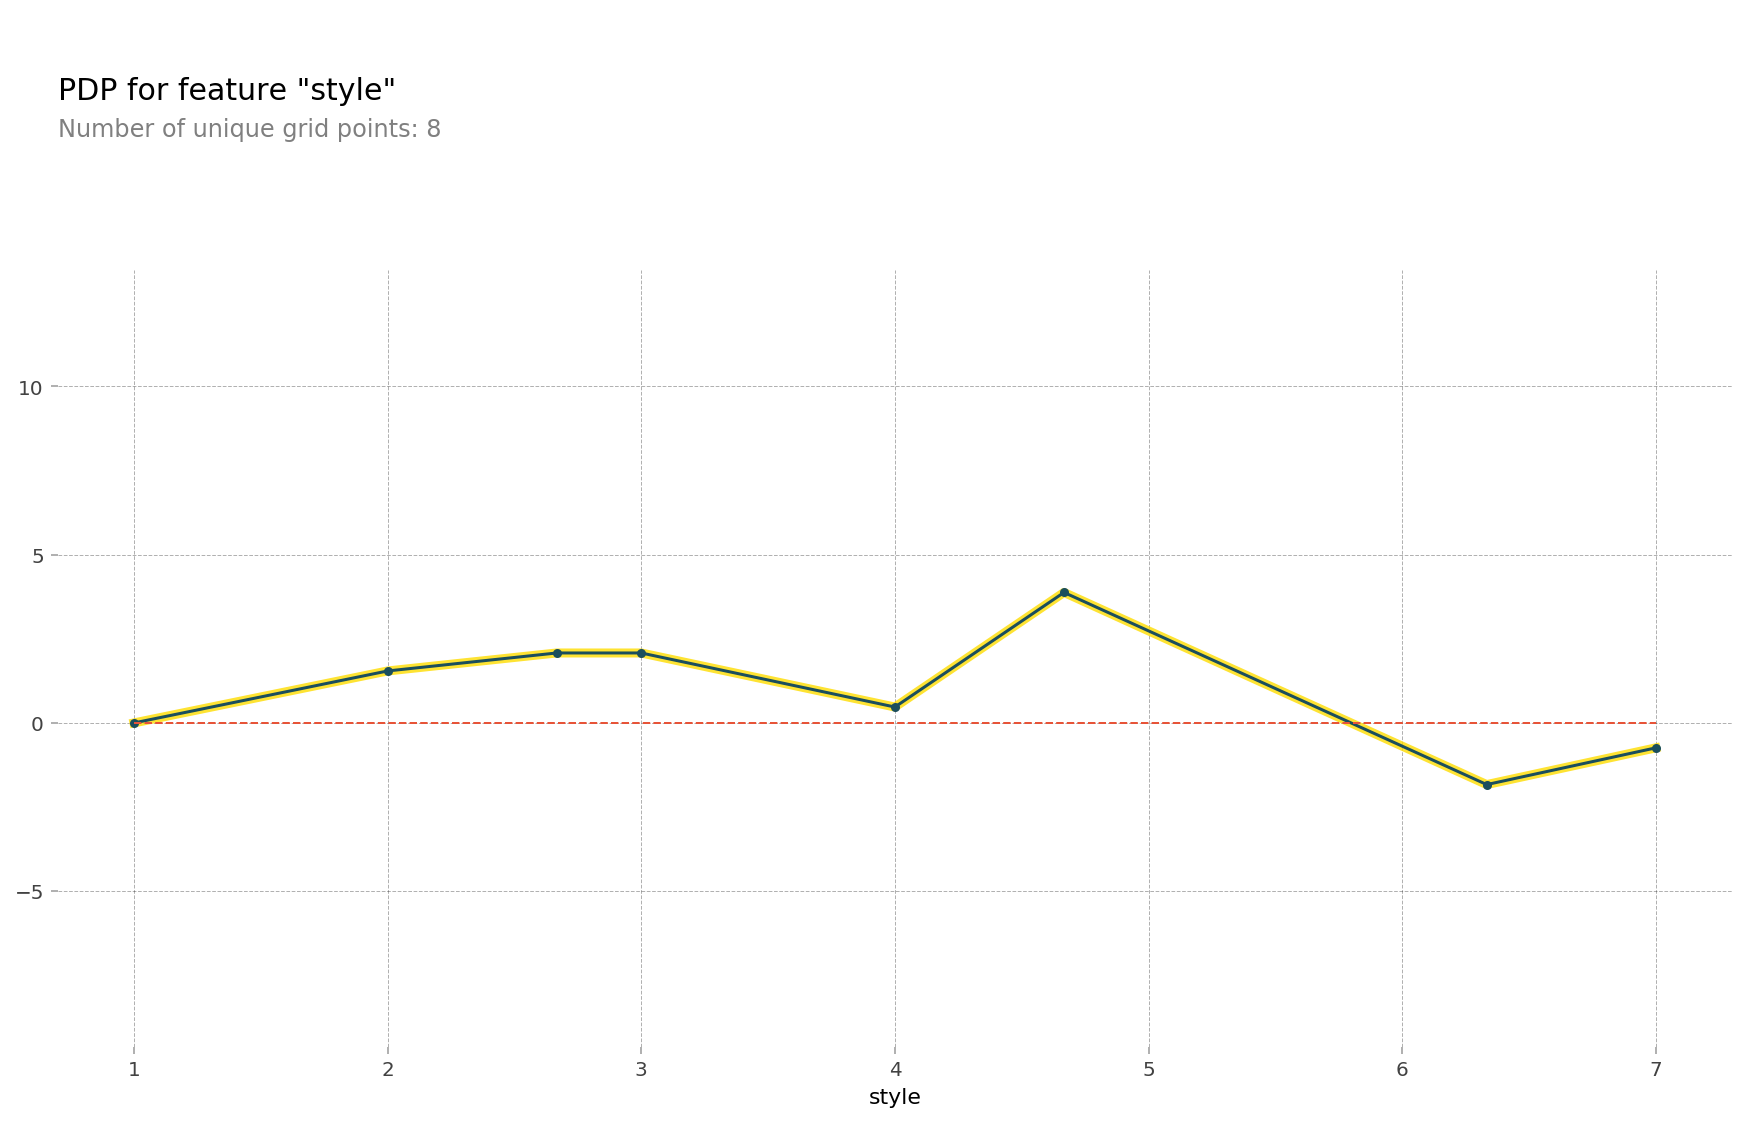

In [66]:
# One other way to visualize this - add ICE curves.
# ICE - Individual Conditional Expectation

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=.01);

In [67]:
# Automate changing the xtick labels.

feature = 'style'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

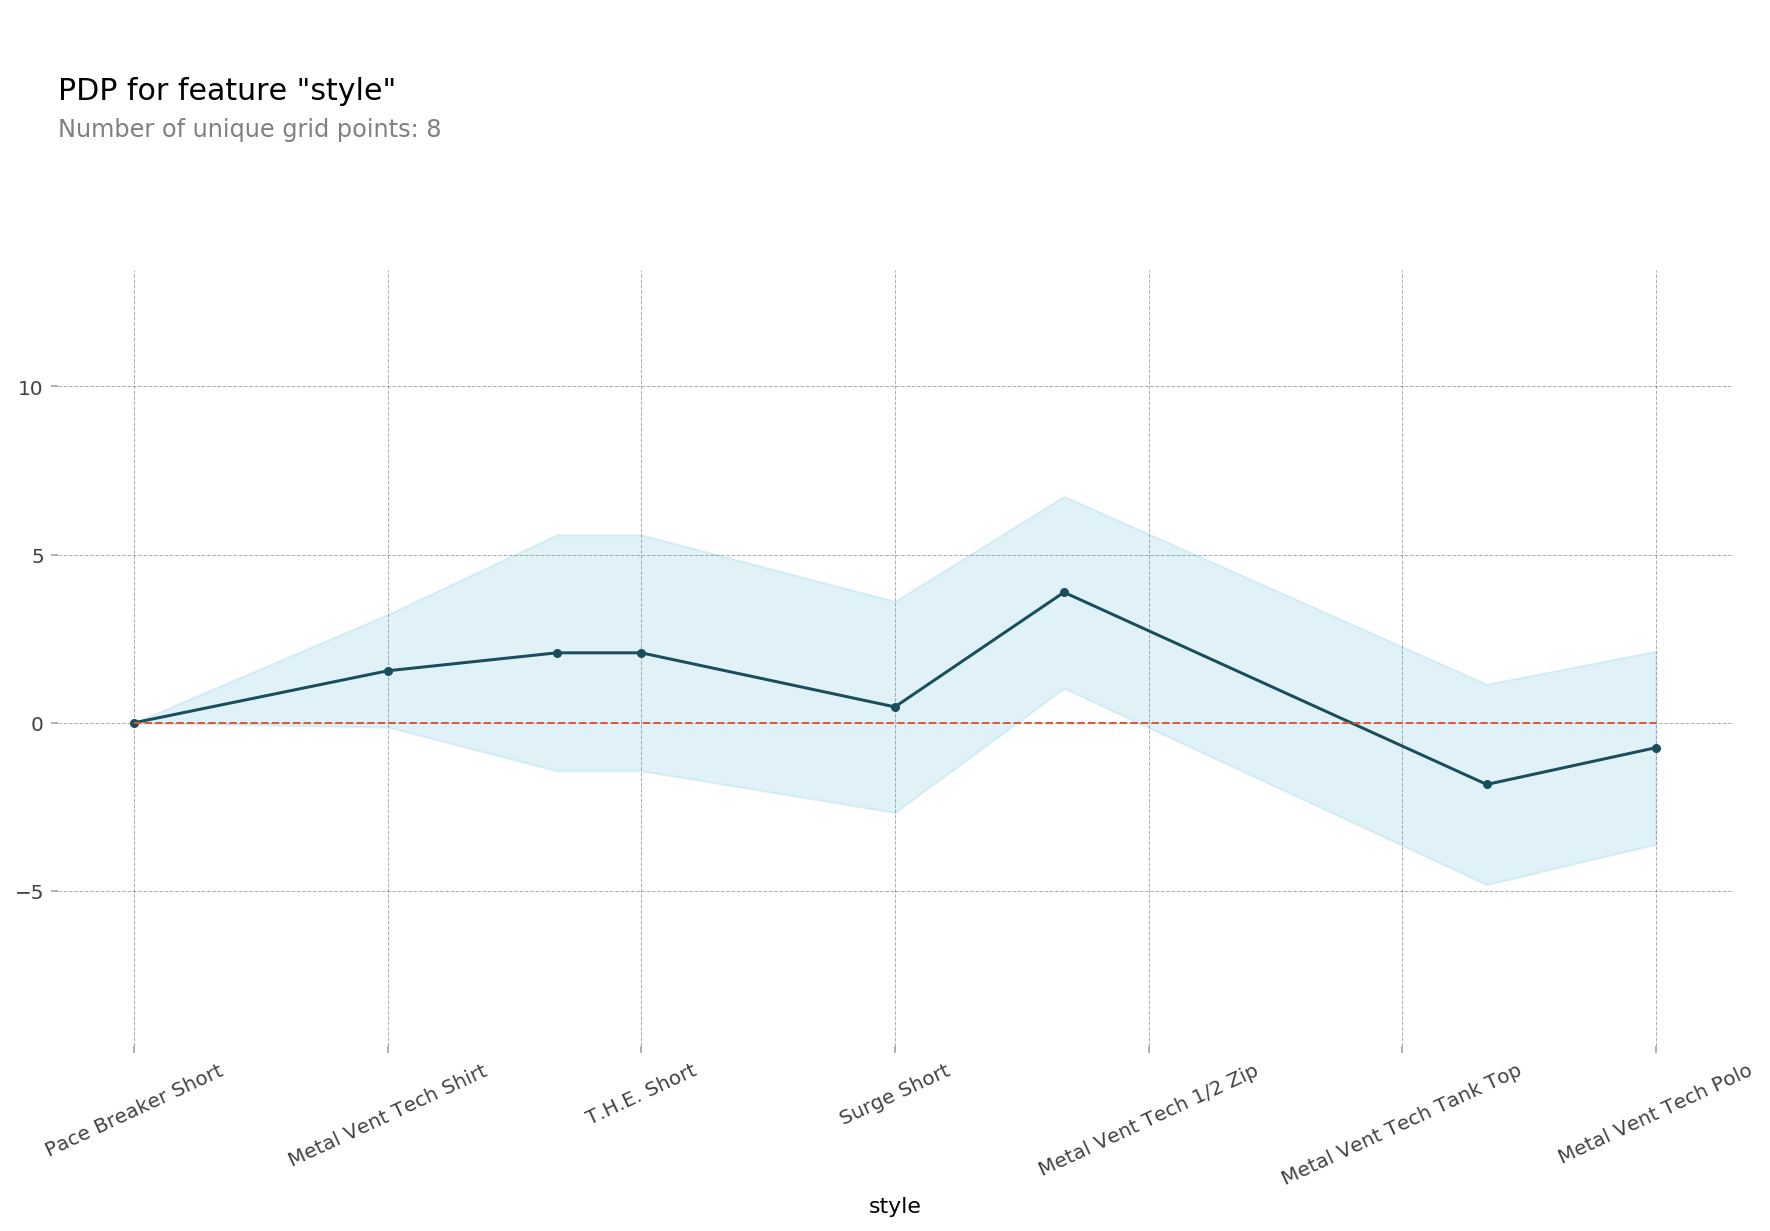

In [68]:
pdp_plot(isolated, feature_name=feature)

# Change xtick labels.

plt.xticks(category_codes, category_names, rotation=25);

### Take a look at another partial dependence plot.

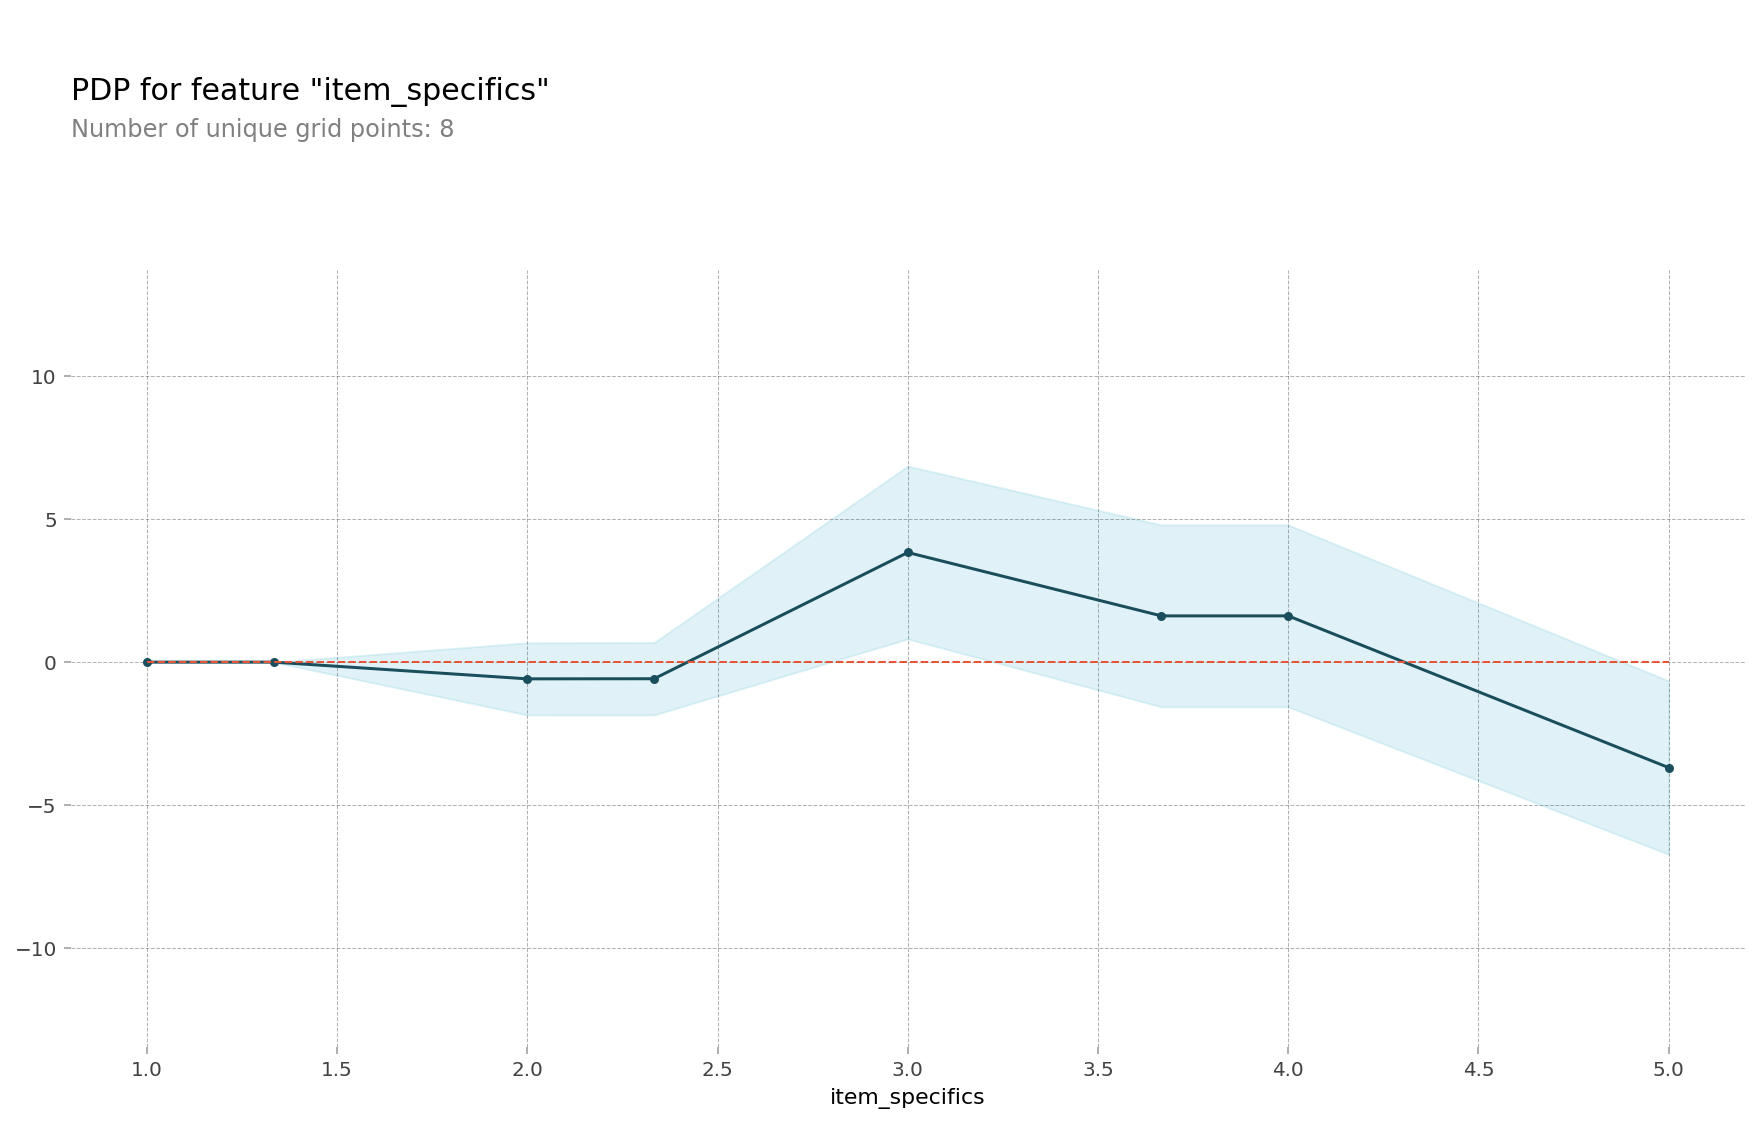

In [31]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'item_specifics'

isolated = pdp_isolate(
    model=model,
    dataset=X_test_encoded,
    model_features=features,
    feature=feature,
    # num_grid_points=15
)

pdp_plot(isolated, feature_name=feature);

# If your plot has more of an outlier, it could be helpful to change the limits.

# Kind of like the range of x you want to zoom in on.
# plt.xlim((20000, 150000))

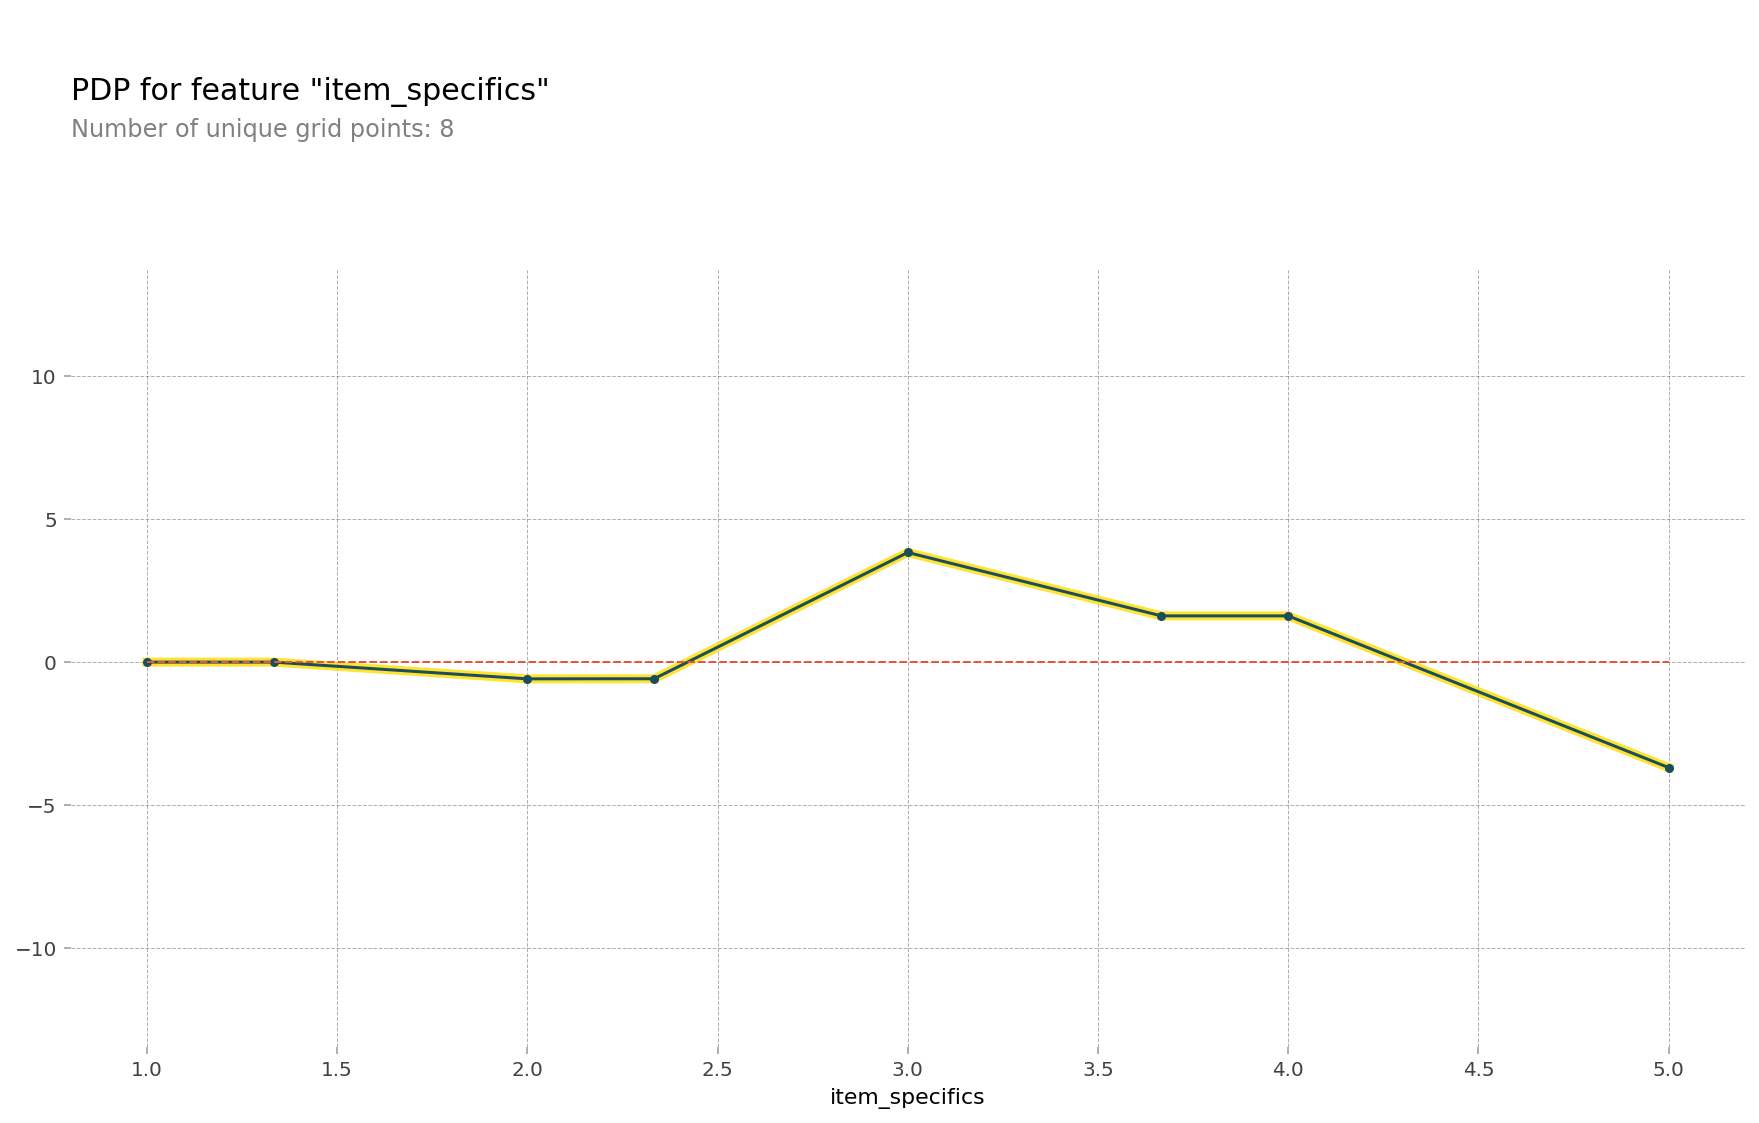

In [32]:
# One other way to visualize this - add ICE curves.
# ICE - Individual Conditional Expectation

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=.01);

In [33]:
# Automate changing the xtick labels.

feature = 'item_specifics'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

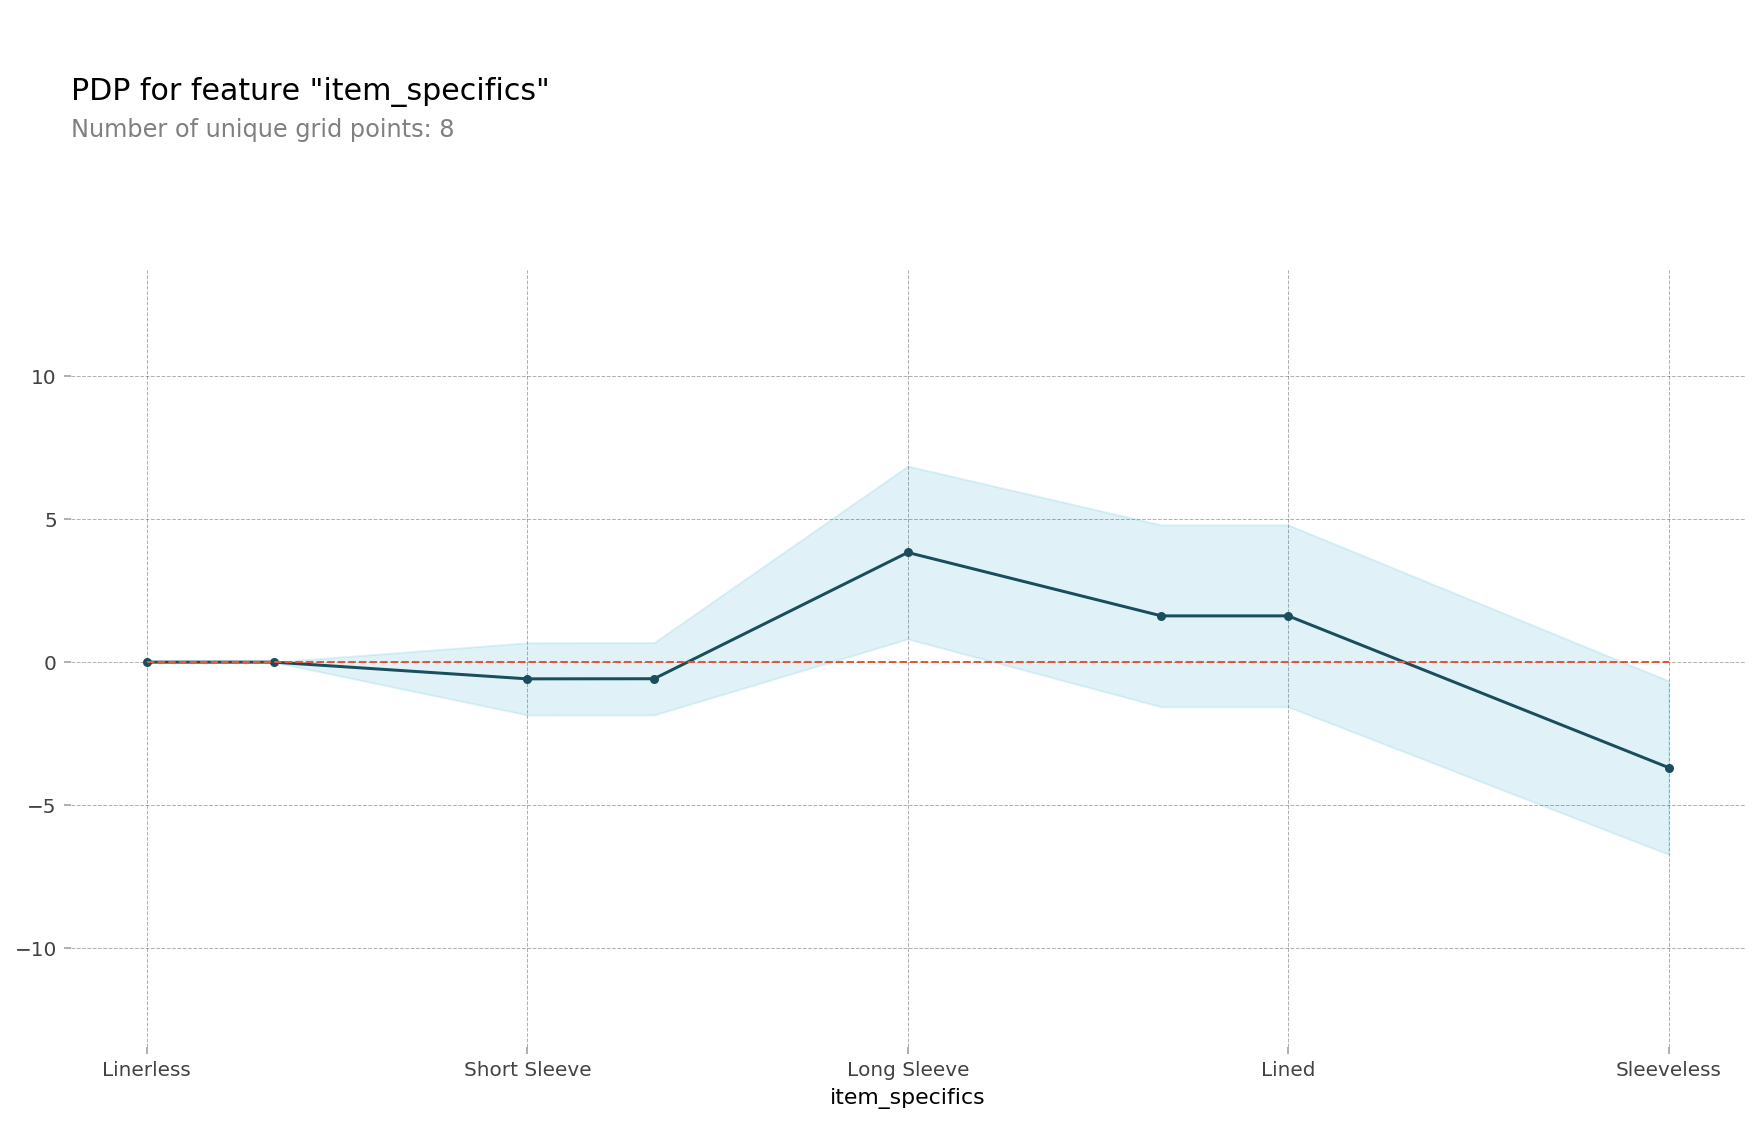

In [36]:
pdp_plot(isolated, feature_name=feature)

# Change xtick labels.

plt.xticks(category_codes, category_names);

### Partial Dependence Plot with 2 Features

In [25]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


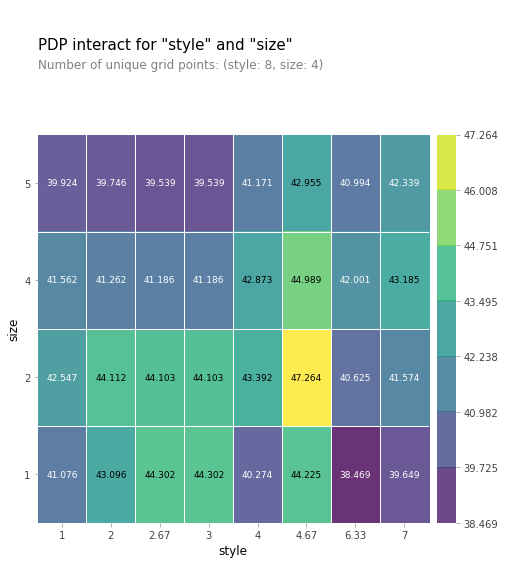

In [26]:
features = ['style', 'size']

interaction = pdp_interact(
    model=model,
    dataset=X_test_encoded,
    model_features=X_test_encoded.columns,
    features=features
)

pdp = pdp_interact_plot(interaction, plot_type='grid', feature_names=features)

pdp;

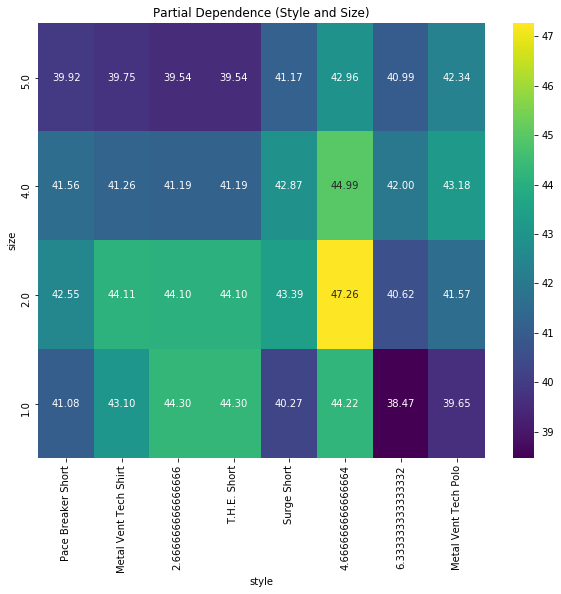

In [27]:
import seaborn as sns

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1],
)[::-1]

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10, 8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence (Style and Size)');

### 3D Plot with Plotly

In [55]:
pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1] # Use slice notation to reverse index order so that the y axis is ascending.

In [56]:
pdp

size            1.0        2.0        4.0        5.0
style                                               
7.000000  39.648797  41.574098  43.184786  42.339497
6.333333  38.468575  40.624987  42.000613  40.993922
4.666667  44.224637  47.264237  44.989085  42.955017
4.000000  40.273971  43.392250  42.873012  41.170992
3.000000  44.302018  44.103282  41.186185  39.539098
2.666667  44.302018  44.103282  41.186185  39.539098
2.000000  43.095939  44.112367  41.261520  39.746476
1.000000  41.076322  42.546687  41.561597  39.923790

In [164]:
import plotly.graph_objs as go

In [165]:
surface = go.Surface(
    x=pdp.columns,
    y=pdp.index,
    z=pdp.values)

layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]),
        yaxis=dict(title=features[1]),
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

Notes for changing datasets from permutation importance...

In [ ]:
# Removing features with zero importance.

print("Shape before removing features:", X_train.shape)

In [ ]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance

In [ ]:
features = X_train.columns[mask]
X_train_selected = X_train[features]
print("Shape after removing features:", X_train_selected.shape)

In [ ]:
X_val_selected = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train and score on val.

pipeline.fit(X_train_selected, y_train)

print('Validation Accuracy:', pipeline.score(X_val_selected, y_val))

In [ ]:
# You could also try removing more features based on standard error.

mask2 = permuter.feature_importances_ - permuter.feature_importances_std_ > 0

# Apply same process as above.

PARTIAL DEPENDENCE PLOTS

In [ ]:
# Partial dependence plots show the relationship between 1-2 individual features
# and the target - how predictions partially depend on the isolated features.

In [ ]:
# How can we explain gradient boosting?
# Linear models have coefficients, but trees do not.

# Instead, to see the relationship between individual feature(s) and the target,
# we can use partial dependence plots.